In [1]:
import IPython.core.display
import matplotlib

def apply_styles():
    matplotlib.rcParams['font.size'] = 12
    matplotlib.rcParams['figure.figsize'] = (18, 6)
    matplotlib.rcParams['lines.linewidth'] = 1

apply_styles()

In [2]:
%%html
<style type="text/css">
@import url('https://fonts.googleapis.com/css?family=Playfair+Display');


div.text_cell_render {font-family: 'Playfair Display', serif; color: #13213b; line-height: 145%; font-size:16px;}
</style>

<span style="color:#13213b;">[Andrii Gakhov](https://www.gakhov.com) / PyCon UA 2018</span>
* * *
## An Introduction to Time Series Forecasting with Python
Time series is an important instrument to model, analyze and predict data collected over time. In this talk, we learn the basic theoretical concepts without going deep into mathematical aspects, study different models, and try them in practice using StatsModels, Prophet, scikit-learn, and keras.

# Part 2. Stochastic Models
******

### OS visits to UK (All visits) 
The dataset represents the monthly total number of visits to the UK by overseas residents (in thousands)<br>from January 1980 to October 2017. 

#### Source: [Office for National Statistics](https://www.ons.gov.uk/peoplepopulationandcommunity/leisureandtourism/timeseries/gmaa/ott)

In [3]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
sns.set(style="ticks")

In [4]:
import warnings
warnings.filterwarnings('ignore')

### Load the data into Pandas DataFrame

In [5]:
import pandas as pd
df = pd.read_csv("data/GMAA-040218.csv", header=None, skiprows=6, parse_dates=[0], names=['period', 'value'])
df.value = df.value.astype(int)

In [6]:
import numpy as np

train_range = df[df.period < '2014-01-01'].index
test_range = df[(df.period >= '2014-01-01')].index

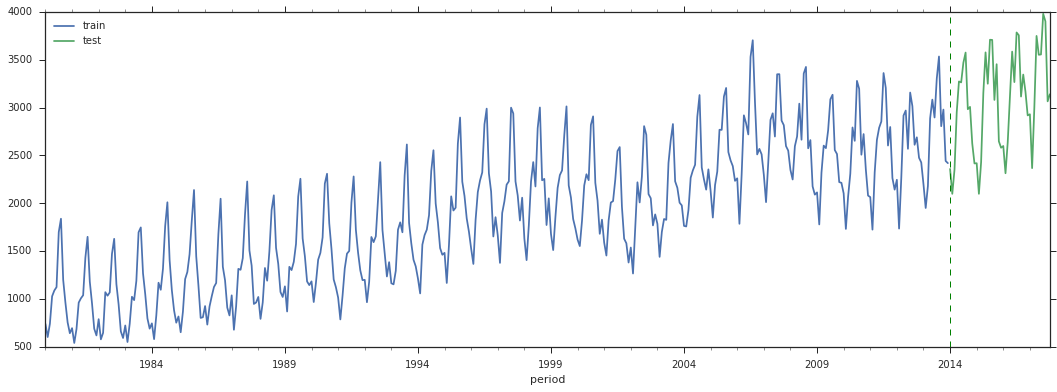

In [7]:
fig, ax = plt.subplots(figsize=(18,6))
df.loc[train_range].plot(x="period", y="value", ax=ax, label="train")
df.loc[test_range].plot(x="period", y="value", ax=ax, label="test")

plt.axvline(pd.to_datetime(str(df.loc[test_range].period.values[0])), c='green', ls='--', lw=1)
plt.legend(loc='upper left')

plt.savefig('images/stochastic-split.png');

# Seasonal ARIMA model

* get AR/MA parameters from the **stationary** series (ARIMA assumes that past factors are stationary.)
* model the seasonal conponent

There are many rules (see, top 13 [here](http://people.duke.edu/~rnau/arimrule.htm)) to identify the best parameters for ARIMA models.


## Stationary or not?

A **non-stationary** time series shows seasonal effects, trends, and other structures that depend on the time index.

A time series is **stationary** if its statistical properties are all constant over time.

[Properties](https://people.duke.edu/~rnau/411arim.htm) of a stationary time series:

* no trend
* variations around its mean have a constant amplitude
* it wiggles in a consistent fashion (i.e., its short-term random time patterns always look the same)


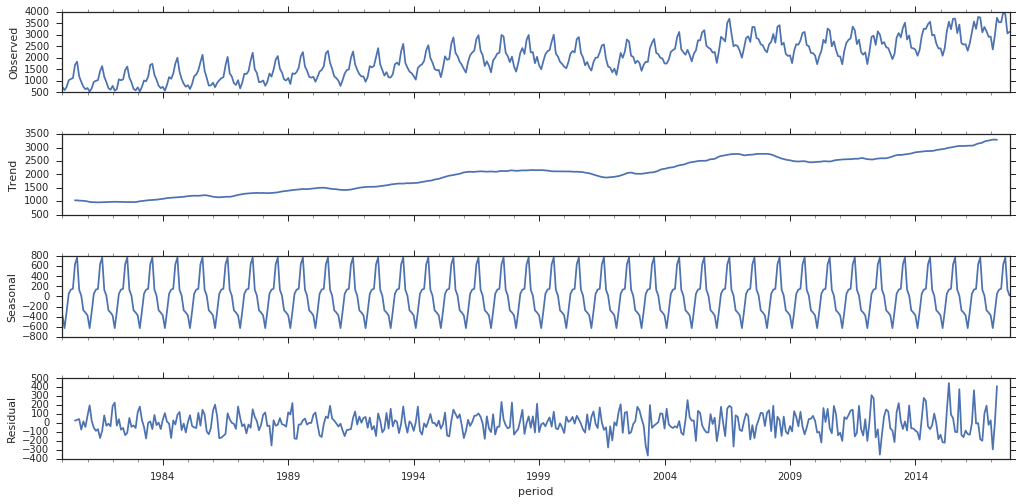

In [8]:
from statsmodels.tsa.seasonal import seasonal_decompose

seasons = 12
decompfreq = seasons
model = 'additive'

decomposition = seasonal_decompose(
    df.set_index("period").value.interpolate("linear"),
    freq=decompfreq,
    model=model)

fig = decomposition.plot()
fig.set_size_inches(16, 8)

plt.savefig('images/stochastic-decomposition.png');

### Augmented Dickey-Fuller ([ADF](https://en.wikipedia.org/wiki/Augmented_Dickey%E2%80%93Fuller_test)) unit root test

The Augmented Dickey-Fuller test is used to test for a **unit root** in a time series sample. The presence of the unit root in time series make it non-stationary (has some time-dependent structure).

The **null hypothesis** of the Augmented Dickey-Fuller is that there is a unit root, with **the alternative** that there is no unit root. 


#### Interpreting the Results

If the ADF statistic is greater than the critical value (available in the tables and returned by the function for significancy levels of 10%, 5% and 1%), then the null hypothesis is rejected, so the unit root is not present and the time series is stationary.

We can also look at the **p-value** returned by the test and compare it to the chosen level of significance. 

In [9]:
from statsmodels.tsa.stattools import adfuller

def is_stationary_with_adf(data, significance_level=0.01):
    """Decide if the given time series is stationary using ADF test."""
    test = adfuller(data, regression='c', autolag='BIC')
    p_value = test[1]
    print("ADF p-value: {:0.5f}".format(p_value))
    return p_value < significance_level

### Kwiatkowski-Phillips-Schmidt-Shin ([KPSS](http://www.statisticshowto.com/kpss-test/)) test for stationarity

The **null hypothesis** of the KPSS test is that the time series is level stationarity or trend stationary (stationary around the deterministic trend), the alternative that there is a unit root.

* Contrary to most unit root tests, the presence of a unit root is not the null hypothesis but the alternative.
* A major disadvantage for the KPSS test is that it has a high rate of Type I errors (it tends to reject the null hypothesis too often).
* One way to deal with the potential for high Type I errors is to combine the KPSS with an ADF test. If the result from both tests suggests that the time series in stationary, then it probably is.

#### Interpreting the Results

If the KPSS statistic is greater than the critical value (given in the table and returned by the function for significancy levels of 10%, 5%, 2.5% and 1%), then the null hypothesis is rejected, so the time series is non-stationary.

We can also look at the **p-value** returned by the test and compare it to the chosen level of significance.

In [10]:
from statsmodels.tsa.stattools import kpss

def is_stationary_with_kpss(data, significance_level=0.05):
    """Decide if the given time series is stationary using KPSS test."""
    test = kpss(data, regression='c')
    p_value = test[1]
    print("KPSS p-value: {:0.5f}".format(p_value))
    return p_value > significance_level

In [11]:
significance_level = 0.05
print("Significance Level: {}%".format(100 * significance_level), '\n')

print("Stationary by ADF: {}".format(
    "yes" if is_stationary_with_adf(df.value.values, significance_level) else "no"), '\n')

print("Stationary by KPSS: {}".format(
    "yes" if is_stationary_with_kpss(df.value.values, significance_level) else "no"))

Significance Level: 5.0% 

ADF p-value: 0.95519
Stationary by ADF: no 

KPSS p-value: 0.01000
Stationary by KPSS: no


### Visual check using Seasonal (rolling) statistics

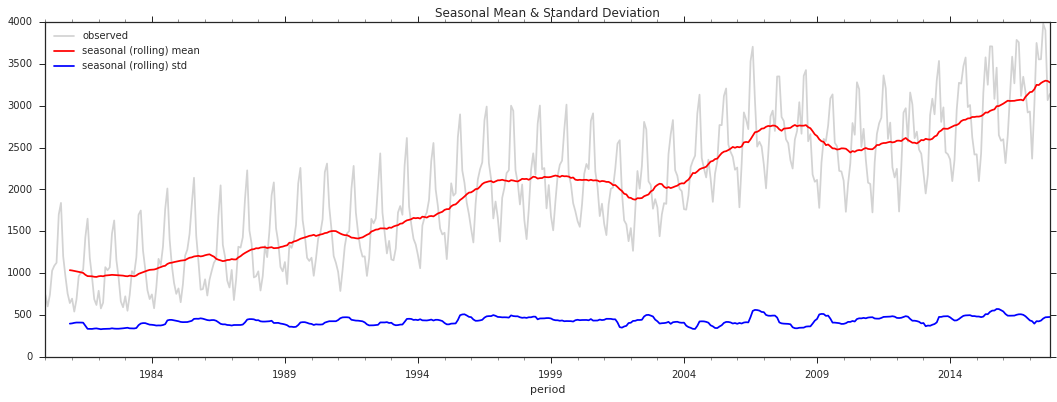

In [12]:
def visual_check(df, value, seasons, save_to=None):
    seasonal_mean = pd.rolling_mean(df.set_index("period"), window=seasons).reset_index()
    seasonal_std = pd.rolling_std(df.set_index("period"), window=seasons).reset_index()

    fig, ax = plt.subplots(figsize=(18,6))
    df.plot(x="period", y=value, ax=ax, label="observed", c='lightgrey')
    seasonal_mean.plot(x="period", y=value, ax=ax, label="seasonal (rolling) mean", c='red')
    seasonal_std.plot(x="period", y=value, ax=ax, label="seasonal (rolling) std", c='blue')

    plt.legend(loc='best')
    plt.title('Seasonal Mean & Standard Deviation')
    
    if save_to is not None:
        plt.savefig(save_to)
    plt.show();
    
visual_check(df, "value", seasons, "images/stochastic-visual-mean-deviation.png")

### Stationarization

We may correct the trend stationarity by differencing (first-difference (FD) - differencing an observation from its prior observation). 

The seasonal growth, if present, can be corrected using a logarithmic transformation or seasonal differences.

#### Box-Cox Transformation 

Lets use the Box-Cox transformation to suppress some of the variance. This technique used to transform non-normal dependent variables into a normal shape.

The Box-Cox transformation is a family of power transformations indexed by a parameter lambda. Whenever you use it the parameter needs to be estimated from the data. 

In time series the process could have a non-constant variance. if the variance changes with time the process is nonstationary. It is often desirable to transform a time series to make it stationary. 

Sometimes after applying Box-Cox with a particular value of lambda the process may look stationary. It is sometimes possible that even if after applying the Box-Cox transformation the series does not appear to be stationary, diagnostics from ARIMA modeling can then be used to decide if differencing or seasonal differencing might be useful to to remove polynomial trends or seasonal trends respectively. 

After that the result might be an ARMA model that is stationary. If diagnostics confirm the orders p an q for the ARMA model, the AR and MA parameters can then be estimated.

In [13]:
from scipy import stats
df['boxcox'], lmbda = stats.boxcox(df.value)

print("Stationary by ADF: {}".format(
    "yes" if is_stationary_with_adf(df.boxcox.dropna().values, significance_level) else "no"), '\n')

print("Stationary by KPSS: {}".format(
    "yes" if is_stationary_with_kpss(df.boxcox.dropna().values, significance_level) else "no"))

ADF p-value: 0.91430
Stationary by ADF: no 

KPSS p-value: 0.01000
Stationary by KPSS: no


#### Remove the overall trend using the first-difference (FD)

In [14]:
df["fd"] = df.boxcox - df.boxcox.shift(1)

#### Remove the seasonality using the seasonal-difference (SD)

In [15]:
df["stationary"] = df.fd - df.fd.shift(seasons)

In [16]:
print("Stationary by ADF: {}".format(
    "yes" if is_stationary_with_adf(df.stationary.dropna().values, significance_level) else "no"), '\n')

print("Stationary by KPSS: {}".format(
    "yes" if is_stationary_with_kpss(df.stationary.dropna().values, significance_level) else "no"))

ADF p-value: 0.00000
Stationary by ADF: yes 

KPSS p-value: 0.10000
Stationary by KPSS: yes


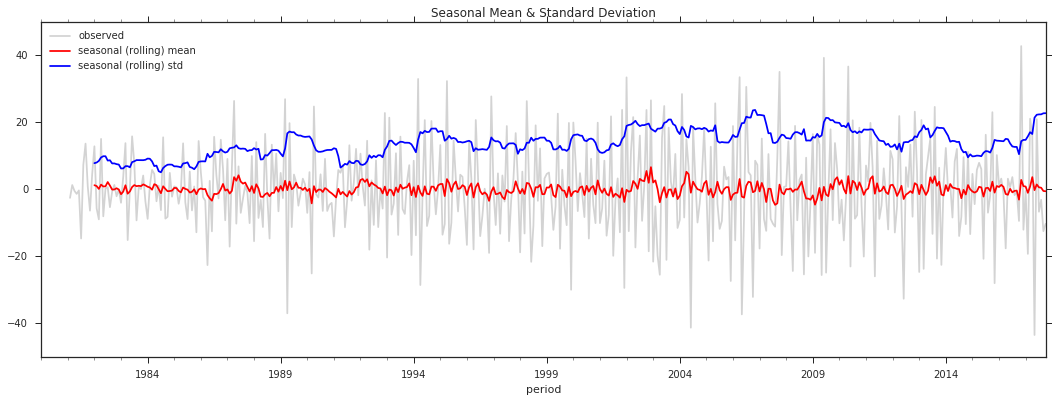

In [17]:
visual_check(df, "stationary", seasons, "images/stochastic-visual-mean-deviation-after-stationarization.png")

## AutoRegressive Integrated Moving Average (ARIMA) Model 

ARIMA models are denoted with the notation $ARIMA (p, d, q)$. These parameters account for seasonality, trend, and noise in datasets:

* p - the number of lag observations to include in the model, or lag order. (AR)
* d - the number of times that the raw observations are differenced, or the degree of differencing. (I)
* q - the size of the moving average window, also called the order of moving average.(MA)

A linear regression model is constructed including the specified number and type of terms, and the data is prepared by a degree of differencing in order to make it stationary, i.e. to remove trend and seasonal structures that negatively affect the regression model. A value of 0 for a parameter indicates to not use that element of the model.

### Determine AR/MA parameters

After a time series has been stationarized, the next step in fitting an ARIMA model is to determine whether AR or MA terms are needed to correct any autocorrelation that remains in the differenced series.

By looking at the **Autocorrelation (ACF)** and **partial autocorrelation (PACF)** functions plots of the stationarized series, we can identify the numbers of AR and/or MA terms that are needed.

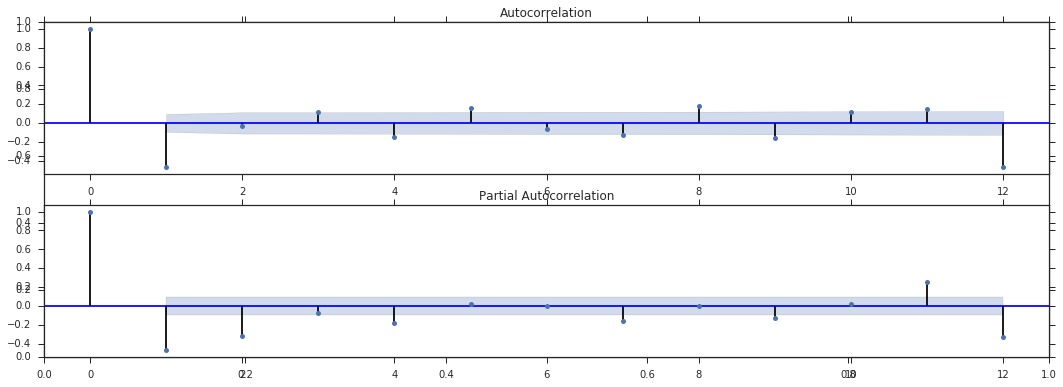

In [18]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

fig, ax = plt.subplots(figsize=(18,6))

ax = fig.add_subplot(211)
fig = plot_acf(df.stationary.dropna(inplace=False).iloc[seasons + 1:], lags=12, ax=ax)

ax = fig.add_subplot(212)
fig = plot_pacf(df.stationary.dropna(inplace=False).iloc[seasons + 1:], lags=12, ax=ax)

plt.savefig('images/stochastic-acf-pacf.png');

At the Autocorrelation (ACF) plot there is a significant positive correlation with the 1 lag, thus a good starting point for the AR parameter of the model may be 1.

Similarly, at the partial autocorrelation (PACF) there is a significant positive correlation with the 1 lag, so the value for the MR parameter make sense to take as 1.

We took differences of the first order to stationarize the time series, so $d=1$.

### Seasonal AutoRegressive Integrated Moving Average with eXogenous regressors  (SARIMAX) Model 

When dealing with seasonal effects, we make use of the seasonal ARIMA, which is denoted as $ARIMA (p,d,q) \times (P,D,Q)_{s}$. Here, (p,d,q) are the non-seasonal parameters described above, while (P, D, Q) follow the same definition but are applied to the seasonal component of the time series. The term $s$ is the seasonal periodicity (4 for quarterly periods, 12 for yearly periods, etc.)

### Build the Model


The AR and MA parameters suggest 1 and 1 respectively, thus giving rise to (P, D, Q) = (1, 1, 1) respectively.

SARIMA $(1,1,1)\times(1,1,0)_{12}$  with an intercept.


The specifing of $(P,D,Q)_{s}$ in the Statsmodels is done simply by adding the **seasonal_order** argument.

* `enforce_stationarity=True` - transform the AR parameters to enforce stationarity in the autoregressive component of the model

* `enforce_invertibility=True` - transform the MA parameters to enforce invertibility in the moving average component of the model.

Read more: https://stats.stackexchange.com/questions/61903/how-to-understand-sarimax-intuitively

In [19]:
from statsmodels.tsa.statespace import sarimax

model = sarimax.SARIMAX(
    np.log(df.loc[train_range].set_index("period").value),
    trend='n',
    order=(1,1,1),
    seasonal_order=(1,1,0,12),
    enforce_stationarity=True,
    enforce_invertibility=True)
results = model.fit()
print(results.summary())

                                 Statespace Model Results                                 
Dep. Variable:                              value   No. Observations:                  408
Model:             SARIMAX(1, 1, 1)x(1, 1, 0, 12)   Log Likelihood                 477.947
Date:                            Wed, 18 Apr 2018   AIC                           -947.894
Time:                                    17:18:24   BIC                           -931.849
Sample:                                01-01-1980   HQIC                          -941.545
                                     - 12-01-2013                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0509      0.075      0.682      0.495      -0.095       0.197
ma.L1         -0.6821      0.051   

## Make prediction

In [21]:
steps = test_range.shape[0]

forecast = results.get_forecast(steps=steps)
forecast_ci = forecast.conf_int()

yhat_test = np.exp(forecast.predicted_mean).values
y_test = df.loc[test_range].value.values

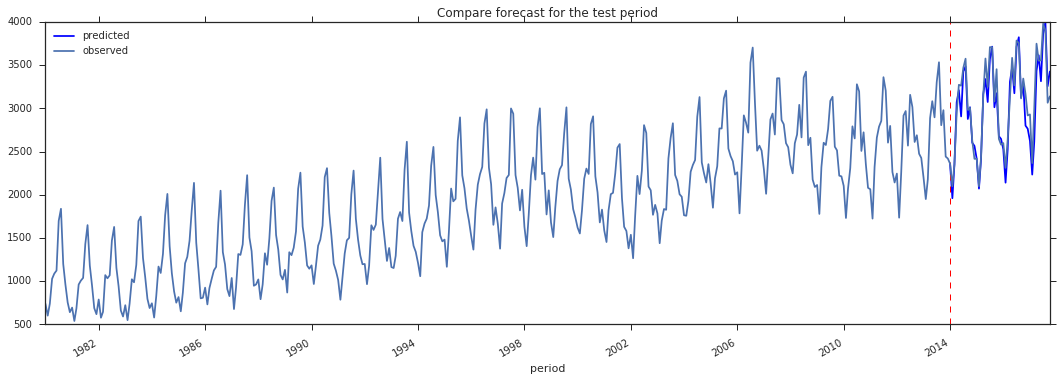

In [22]:
fig, ax = plt.subplots(figsize=(18,6))
ax.plot(pd.to_datetime(df.loc[test_range].period.values), yhat_test,
        color="blue", label="predicted")

plt.axvline(pd.to_datetime(str(df.loc[test_range].period.values[0])), c='red', ls='--', lw=1)
df.plot(x="period", y="value", ax=ax, label="observed")

plt.legend(loc='best')
plt.title('Compare forecast for the test period')

plt.savefig('images/stochastic-forecast-testrange.png')
plt.show();

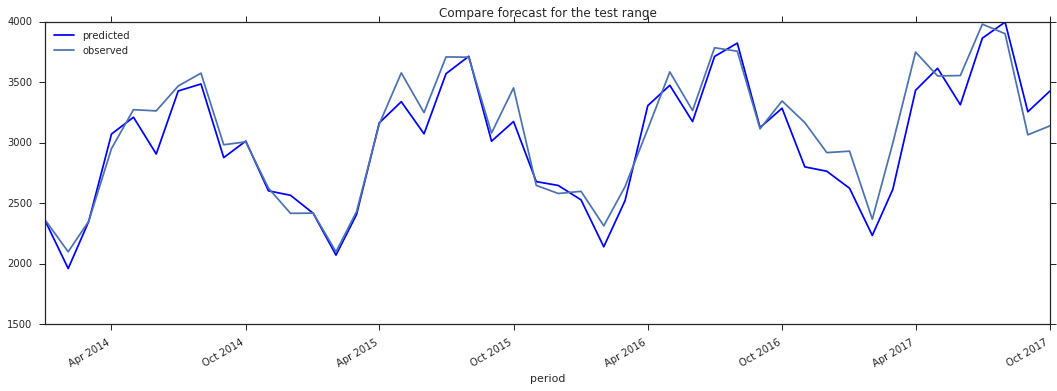

In [23]:
fig, ax = plt.subplots(figsize=(18,6))
ax.plot(pd.to_datetime(df.loc[test_range].period.values), yhat_test,
        color="blue", label="predicted")

df.loc[test_range].plot(x="period", y="value", ax=ax, label="observed")
plt.legend(loc='best')
plt.title('Compare forecast for the test range')

plt.savefig('images/stochastic-forecast-testrange-zoom.png')
plt.show();

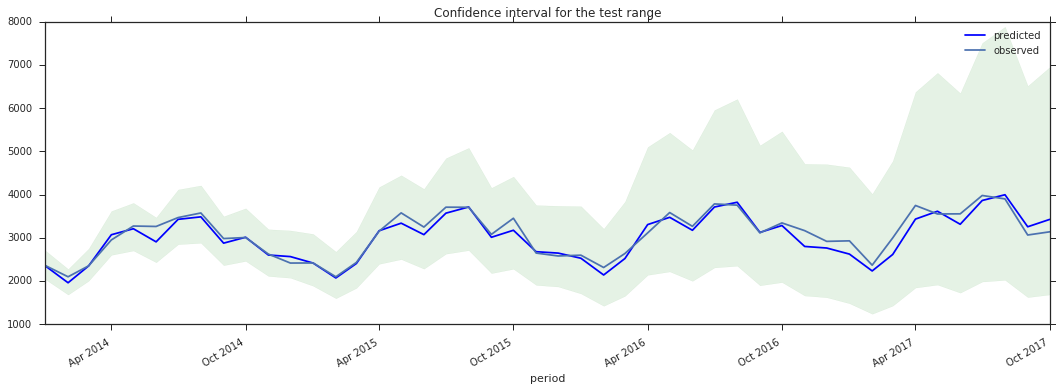

In [24]:
fig, ax = plt.subplots(figsize=(18,6))
ax.plot(pd.to_datetime(df.loc[test_range].period.values), yhat_test,
        color="blue", label="predicted")

ax.fill_between(
    forecast_ci.index.to_pydatetime(),
    np.exp(forecast_ci['lower value']),
    np.exp(forecast_ci['upper value']),
    color='g',
    alpha=0.1)

df.loc[test_range].plot(x="period", y="value", ax=ax, label="observed")

plt.legend(loc='best')
plt.title('Confidence interval for the test range')

plt.savefig('images/stochastic-forecast-testrange-confidence-interval.png')
plt.show();

### Evaluate the forecast

In [25]:
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

def theils_u_metric(y_true, y_pred):
    """Calculate Theil's U statistics using observed and predicted vectors."""
    SS_res =  np.mean(np.square(y_true - y_pred))
    SS_true = np.mean(np.square(y_true))
    SS_pred = np.mean(np.square(y_pred))
    
    return np.sqrt(SS_res / (SS_true * SS_pred))

In [26]:
mae = mean_absolute_error(y_test, yhat_test)
mse = mean_squared_error(y_test, yhat_test)
r2 = r2_score(y_test, yhat_test)
u = theils_u_metric(y_test, yhat_test)

print("MAE (test): {:0.0f}".format(mae))
print("MSE (test): {:0.0f}".format(mse))
print("R2  (test): {:0.3f}".format(r2))
print("U   (test): {:0.6f}".format(u))

MAE (test): 126
MSE (test): 27015
R2  (test): 0.896
U   (test): 0.000017
